# What Are The Most Profitable Genres?


In [1]:
# import statements
import pandas as pd
import numpy as np
import requests as rq
import sqlite3
from sklearn.preprocessing import OneHotEncoder
from zipfile import ZipFile
import tarfile
import gzip
import matplotlib.pyplot as plt
from collections import OrderedDict
from operator import itemgetter

# Data Acquisition

In [2]:
# IMDB Name Data    
with gzip.open("zippedData/imdb.name.basics.csv.gz", "rb") as f:
    imdb_name_basics = pd.read_csv(f)

with gzip.open("zippedData/imdb.title.akas.csv.gz", "rb") as f:
    imdb_title_akas = pd.read_csv(f)

with gzip.open("zippedData/imdb.title.basics.csv.gz", "rb") as f:
    imdb_title_basics = pd.read_csv(f)

with gzip.open("zippedData/imdb.title.crew.csv.gz", "rb") as f:
    imdb_title_crew = pd.read_csv(f)
    
with gzip.open("zippedData/imdb.title.principals.csv.gz", "rb") as f:
    imdb_title_principals = pd.read_csv(f)

with gzip.open("zippedData/imdb.title.ratings.csv.gz", "rb") as f:
    imdb_title_ratings = pd.read_csv(f)
    
# TN Movie Data
with gzip.open("zippedData/tn.movie_budgets.csv.gz", "rb") as f:
    tn_movie_budgets = pd.read_csv(f)

# Data Exploration

In [6]:
#tn_movie_budgets.info
#tn_movie_budgets.describe
tn_movie_budgets.head(1)

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"


In [4]:
imdb_title_akas.head(1)

,title_id,ordering,title,region,language,types,attributes,is_original_title
0,tt0369610,10,Джурасик свят,BG,bg,NaN,NaN,0.0


In [5]:
imdb_title_basics.head(1)

,tconst,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama"


# Data Cleaning

In [6]:
# Select only movies from US region and change column 'title' to 'movie'
x_df = imdb_title_akas.loc[imdb_title_akas['region'] == 'US']
x_df = x_df.rename(columns={'title': 'movie'})

In [7]:
x_df.head(1)

,title_id,ordering,movie,region,language,types,attributes,is_original_title
12,tt0369610,21,Jurassic World 3D,US,NaN,NaN,3-D version,0.0


In [8]:
# Merge tn_movie_budgets and x_df on tn_movie_budgets DF
gross_df = pd.merge(tn_movie_budgets, x_df, how='left', on='movie')

In [9]:
gross_df.head(1)

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,title_id,ordering,region,language,types,attributes,is_original_title
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279",NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
# Clean and turn 'worldwide_gross' into float for accurate sorting
gross_df['worldwide_gross'] = gross_df['worldwide_gross'].str.replace(',', '')
gross_df['worldwide_gross'] = gross_df['worldwide_gross'].str.replace('$', '')
gross_df['worldwide_gross'] = gross_df['worldwide_gross'].astype(float)
gross_df1 = gross_df.sort_values('worldwide_gross', ascending=False)

In [11]:
# Clean and turn 'production_budget' into float for accurate sorting
gross_df['production_budget'] = gross_df['production_budget'].str.replace(',', '')
gross_df['production_budget'] = gross_df['production_budget'].str.replace('$', '')
gross_df1['production_budget'] = gross_df['production_budget'].astype(float)

In [12]:
# Clean unused columns
movie_df = gross_df1.drop(['id', 'ordering', 'region', 'language', 
                           'types', 'attributes', 'is_original_title'], axis=1)

In [13]:
# Drop all duplicate film entries
movie_df = movie_df.drop_duplicates()

In [14]:
movie_df.head(1)

,release_date,movie,production_budget,domestic_gross,worldwide_gross,title_id
0,"Dec 18, 2009",Avatar,425000000.0,"$760,507,625",2.776345e+09,NaN


In [15]:
imdb_title_basics.head(1)

,tconst,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama"


In [16]:
# Change 'primary_title' to 'movie'
imdb_title_basics = imdb_title_basics.rename(columns={'primary_title': 'movie'})

In [17]:
# Merge movie_df and imdb_title_basics on 'movie'
genere_df = pd.merge(movie_df, imdb_title_basics, how='left', on='movie')

In [18]:
# Drop NaNs from 'genres'
genere_df = genere_df.dropna(subset=['genres'])

In [19]:
# Create a new column to reflect total profit
genere_df['profit'] = genere_df['worldwide_gross'] - genere_df['production_budget']

In [20]:
genere_df.head(1)

,release_date,movie,production_budget,domestic_gross,worldwide_gross,title_id,tconst,original_title,start_year,runtime_minutes,genres,profit
0,"Dec 18, 2009",Avatar,425000000.0,"$760,507,625",2.776345e+09,NaN,tt1775309,Abatâ,2011.0,93.0,Horror,2.351345e+09


In [21]:
# Create list of items in 'generes' column
list_of_genres = []
for key, value in genere_df['genres'].items():
    list_of_genres.append(value)

In [22]:
list_of_genres[0:5]

['Horror',
 'Adventure',
 'Family',
 'Action,Adventure,Sci-Fi',
 'Action,Adventure,Sci-Fi']

In [23]:
# Split list of genre columns
list_of_genres_full = []
for x in list_of_genres:
    list_of_genres_full.append(str(x).split(','))

In [24]:
list_of_genres_full[0:5]

[['Horror'],
 ['Adventure'],
 ['Family'],
 ['Action', 'Adventure', 'Sci-Fi'],
 ['Action', 'Adventure', 'Sci-Fi']]

In [25]:
# Create list of individual genres
genre_list = []
for element in list_of_genres_full:
    for item in element:
        if item not in genre_list:
            genre_list.append(item)

In [26]:
print(genre_list)

['Horror', 'Adventure', 'Family', 'Action', 'Sci-Fi', 'Crime', 'Thriller', 'Drama', 'Sport', 'Fantasy', 'Romance', 'Animation', 'Comedy', 'Musical', 'Documentary', 'Biography', 'Music', 'History', 'Mystery', 'Western', 'War', 'News', 'Reality-TV']


In [27]:
# Create genre dictionary for gross with key 0
genre_dict_gross = { i : 0 for i in genre_list }

In [28]:
print(genre_dict_gross)

{'Horror': 0, 'Adventure': 0, 'Family': 0, 'Action': 0, 'Sci-Fi': 0, 'Crime': 0, 'Thriller': 0, 'Drama': 0, 'Sport': 0, 'Fantasy': 0, 'Romance': 0, 'Animation': 0, 'Comedy': 0, 'Musical': 0, 'Documentary': 0, 'Biography': 0, 'Music': 0, 'History': 0, 'Mystery': 0, 'Western': 0, 'War': 0, 'News': 0, 'Reality-TV': 0}


In [29]:
# Make genre dictionary key equal to total worldwide gross for each genre
for index, row in genere_df.iterrows():
    gross = row['worldwide_gross']
    list_g = row['genres'].split(',')
    for i in list_g:
        genre_dict_gross[i] += gross

In [30]:
print(genre_dict_gross)

{'Horror': 38354358106.0, 'Adventure': 157260197402.0, 'Family': 51897204624.0, 'Action': 142056063685.0, 'Sci-Fi': 57287725647.0, 'Crime': 33726234053.0, 'Thriller': 66868002199.0, 'Drama': 182209412385.0, 'Sport': 8559405290.0, 'Fantasy': 53524012785.0, 'Romance': 35082967734.0, 'Animation': 56987821436.0, 'Comedy': 105205531703.0, 'Musical': 11941698836.0, 'Documentary': 87960442916.0, 'Biography': 30308030313.0, 'Music': 7069301234.0, 'History': 17234734622.0, 'Mystery': 23387901261.0, 'Western': 1696227711.0, 'War': 6298524339.0, 'News': 879951568.0, 'Reality-TV': 0.0}


In [31]:
# Create genre dictionary for profit with key 0
genre_dict_profit = { i : 0 for i in genre_list }

In [32]:
# Make genre dictionary key equal to total profit for each genre
for index, row in genere_df.iterrows():
    profit = row['profit']
    list_g = row['genres'].split(',')
    for i in list_g:
        genre_dict_profit[i] += profit

In [33]:
print(genre_dict_profit)

{'Horror': 25405160914.0, 'Adventure': 108104686296.0, 'Family': 35763983130.0, 'Action': 89818339255.0, 'Sci-Fi': 40604389155.0, 'Crime': 19267826838.0, 'Thriller': 40341064133.0, 'Drama': 109330283067.0, 'Sport': 5970930290.0, 'Fantasy': 38296517797.0, 'Romance': 23157452734.0, 'Animation': 41594854942.0, 'Comedy': 70735303592.0, 'Musical': 9687209589.0, 'Documentary': 55103496421.0, 'Biography': 19136082223.0, 'Music': 5168431234.0, 'History': 10250774622.0, 'Mystery': 15408489119.0, 'Western': 467627711.0, 'War': 3679324339.0, 'News': 418351568.0, 'Reality-TV': -2000000.0}


In [34]:
# Create genre dictionary for amount of movies with key 0
genre_dict_count = { i : 0 for i in genre_list }

In [35]:
# Make genre dictionary key equal to total profit for each genre
for index, row in genere_df.iterrows():
    list_g = row['genres'].split(',')
    for i in list_g:
        genre_dict_count[i] += 1

In [36]:
print(genre_dict_count)

{'Horror': 623, 'Adventure': 625, 'Family': 367, 'Action': 940, 'Sci-Fi': 288, 'Crime': 538, 'Thriller': 998, 'Drama': 2964, 'Sport': 109, 'Fantasy': 246, 'Romance': 560, 'Animation': 218, 'Comedy': 1098, 'Musical': 56, 'Documentary': 1099, 'Biography': 385, 'Music': 116, 'History': 177, 'Mystery': 383, 'Western': 41, 'War': 86, 'News': 14, 'Reality-TV': 2}


In [37]:
# Get the average gross
for key in genre_dict_gross:
    genre_dict_gross[key] /= genre_dict_count[key]

In [38]:
print(genre_dict_gross)

{'Horror': 61563977.69823435, 'Adventure': 251616315.8432, 'Family': 141409276.90463215, 'Action': 151123472.00531915, 'Sci-Fi': 198915714.05208334, 'Crime': 62688167.38475836, 'Thriller': 67002006.211422846, 'Drama': 61474160.723684214, 'Sport': 78526654.03669725, 'Fantasy': 217577287.74390244, 'Romance': 62648156.66785714, 'Animation': 261412024.9357798, 'Comedy': 95815602.643898, 'Musical': 213244622.07142857, 'Documentary': 80036799.74158326, 'Biography': 78722156.65714286, 'Music': 60942252.01724138, 'History': 97371382.04519774, 'Mystery': 61065016.347258486, 'Western': 41371407.585365854, 'War': 73238655.10465117, 'News': 62853683.428571425, 'Reality-TV': 0.0}


In [39]:
# Get the average profit
for key in genre_dict_profit:
    genre_dict_profit[key] /= genre_dict_count[key]

In [49]:
print(genre_dict_profit)

{'Horror': 40778749.46067416, 'Adventure': 172967498.0736, 'Family': 97449545.3133515, 'Action': 95551424.7393617, 'Sci-Fi': 140987462.34375, 'Crime': 35813804.531598516, 'Thriller': 40421907.948897794, 'Drama': 36886060.41396761, 'Sport': 54779176.97247706, 'Fantasy': 155676901.61382115, 'Romance': 41352594.16785714, 'Animation': 190802086.88990825, 'Comedy': 64421952.26958106, 'Musical': 172985885.51785713, 'Documentary': 50139669.17288444, 'Biography': 49704109.67012987, 'Music': 44555441.672413796, 'History': 57913980.915254235, 'Mystery': 40231042.08616188, 'Western': 11405553.92682927, 'War': 42782841.15116279, 'News': 29882254.85714286, 'Reality-TV': -1000000.0}


# Visualizations

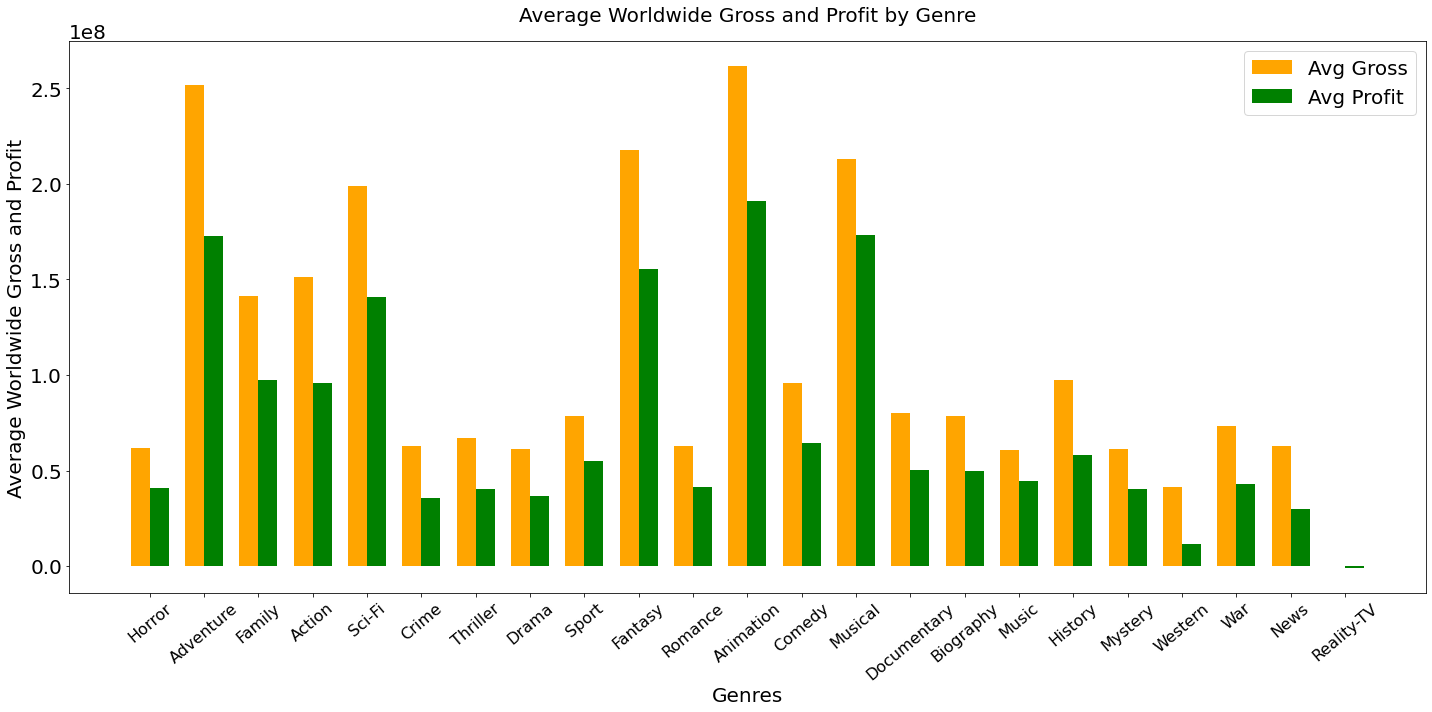

In [48]:
# Draw a double bar graph of the data
fig, ax = plt.subplots(figsize=(20,10))

labels = genre_dict_profit.keys()
width  = 0.35

x  = np.arange(len(labels))
y1 = genre_dict_gross.values()
y2 = genre_dict_profit.values()

rects1 = ax.bar(x- width/2, y1, width, color='orange', label='Avg Gross')
rects2 = ax.bar(x+ width/2, y2, width, color='green', label='Avg Profit')

ax.set_xticks(x)
ax.set_xticklabels(labels)
plt.rc('xtick', labelsize=16) 
plt.xticks(rotation=40)
plt.rc('ytick', labelsize=20)

ax.set_xlabel('Genres', fontsize=20)
ax.set_ylabel('Average Worldwide Gross and Profit', fontsize=20)
ax.set_title('Average Worldwide Gross and Profit by Genre', pad=20, fontsize=20)
ax.legend(loc=1, prop={'size': 20})

fig.tight_layout()
plt.show()

In [42]:
# Sort genre_dict_gross from highest to lowest
genre_dict_gross1 = OrderedDict(sorted(genre_dict_gross.items(), key=itemgetter(1), reverse=True))

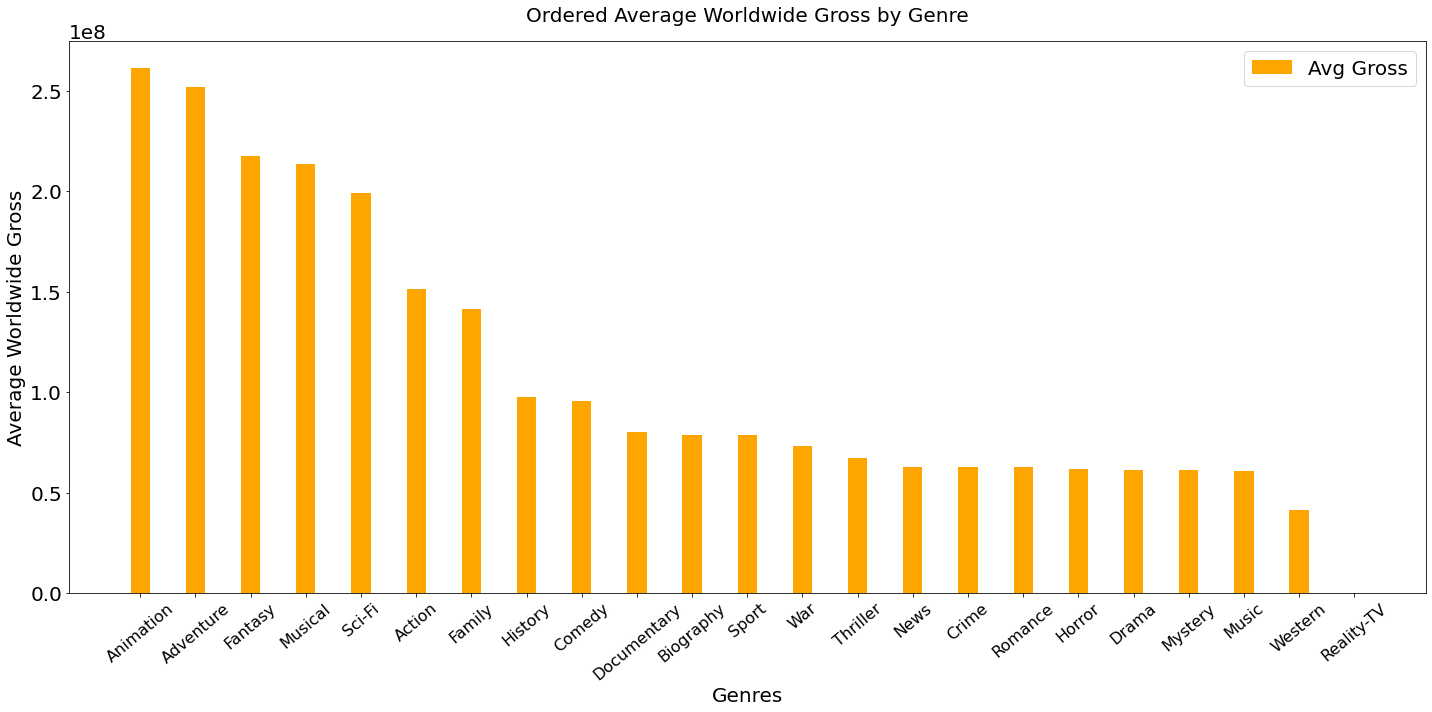

In [45]:
# Draw a sorted bar graph of average gross per genre
fig, ax = plt.subplots(figsize=(20,10))

labels = genre_dict_gross1.keys()
width  = 0.35

x  = np.arange(len(labels))
y  = genre_dict_gross1.values()

ax.bar(x, y, width, color='orange', label='Avg Gross')
ax.set_xticks(x)
ax.set_xticklabels(labels)
plt.rc('xtick', labelsize=16) 
plt.xticks(rotation=40)
plt.rc('ytick', labelsize=20)

ax.set_xlabel('Genres', fontsize=20)
ax.set_ylabel('Average Worldwide Gross', fontsize=20)
ax.set_title('Ordered Average Worldwide Gross by Genre', pad=20, fontsize=20)
ax.legend(loc=1, prop={'size': 20})

fig.tight_layout()
plt.show()

In [46]:
# Sort genre_dict_profit from highest to lowest
genre_dict_profit1 = OrderedDict(sorted(genre_dict_profit.items(), key=itemgetter(1), reverse=True))

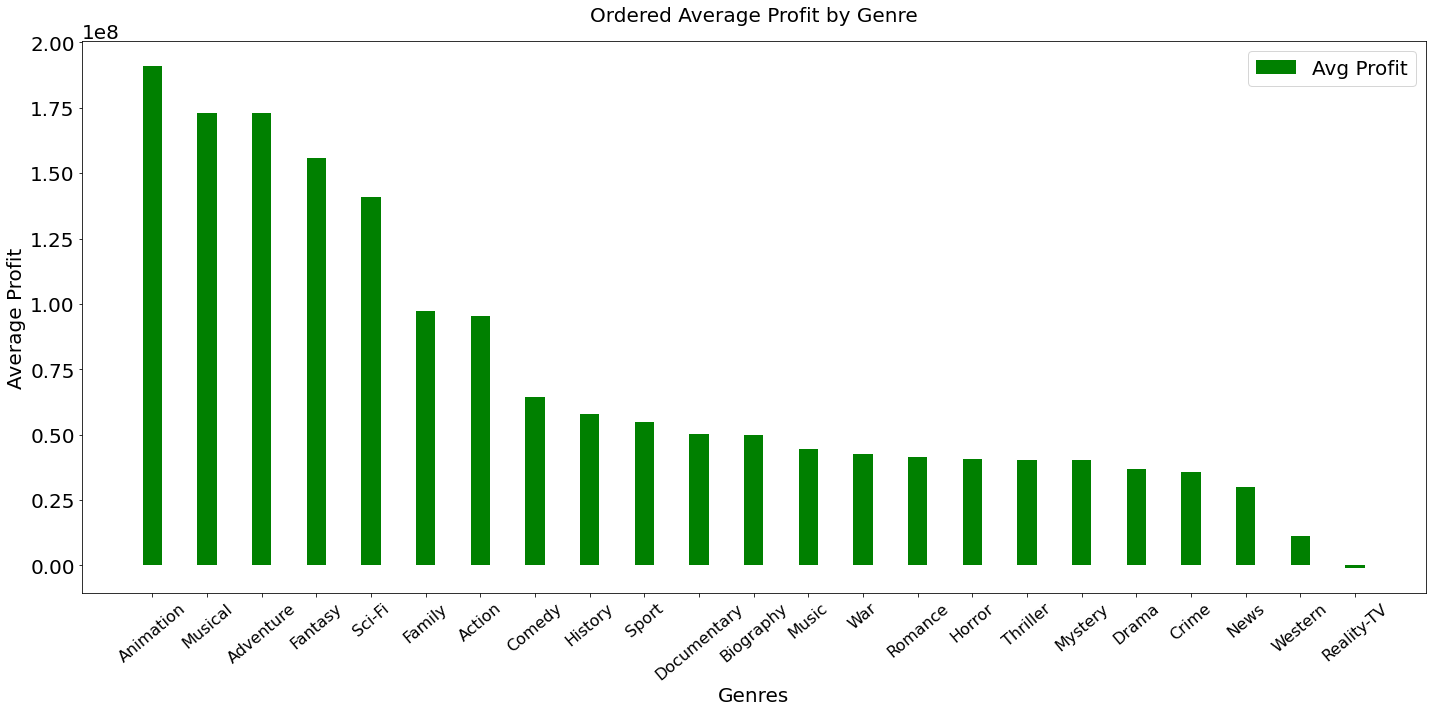

In [47]:
# Draw a sorted bar graph of average profit per genre
fig, ax = plt.subplots(figsize=(20,10))

labels = genre_dict_profit1.keys()
width  = 0.35

x  = np.arange(len(labels))
y  = genre_dict_profit1.values()

ax.bar(x, y, width, color='green', label='Avg Profit')
ax.set_xticks(x)
ax.set_xticklabels(labels)
plt.rc('xtick', labelsize=16) 
plt.xticks(rotation=40)
plt.rc('ytick', labelsize=20)

ax.set_xlabel('Genres', fontsize=20)
ax.set_ylabel('Average Profit', fontsize=20)
ax.set_title('Ordered Average Profit by Genre', pad=20, fontsize=20)
ax.legend(loc=1, prop={'size': 20})

fig.tight_layout()
plt.show()